In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from collections import deque
from dataclasses import dataclass
from pathlib import Path
from typing import Optional

import draccus
import torch
import torch.distributed as dist
import tqdm
from accelerate import PartialState
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig
from transformers import AutoConfig, AutoImageProcessor
from transformers.modeling_outputs import CausalLMOutputWithPast

import wandb
from prismatic.models.backbones.llm.prompting import PurePromptBuilder, VicunaV15ChatPromptBuilder
from prismatic.util.data_utils import PaddedCollatorForActionPrediction
from prismatic.vla.action_tokenizer import ActionTokenizer
from prismatic.vla.datasets import RLDSBatchTransform, RLDSDataset, EpisodicRLDSDataset
from prismatic.vla.datasets.rlds.utils.data_utils import save_dataset_statistics

from prismatic.extern.hf.configuration_prismatic import OpenVLAConfig
from prismatic.extern.hf.modeling_prismatic import OpenVLAForActionPrediction
from prismatic.extern.hf.processing_prismatic import PrismaticImageProcessor, PrismaticProcessor

# Sane Defaults
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-20 21:04:57.417862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-20 21:04:57.417989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-20 21:04:57.456821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-20 21:04:57.549218: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
AutoConfig.register("openvla", OpenVLAConfig)
AutoImageProcessor.register(OpenVLAConfig, PrismaticImageProcessor)
AutoProcessor.register(OpenVLAConfig, PrismaticProcessor)
AutoModelForVision2Seq.register(OpenVLAConfig, OpenVLAForActionPrediction)

In [4]:
processor = AutoProcessor.from_pretrained("openvla/openvla-7b", trust_remote_code=True)

In [ ]:
vla = AutoModelForVision2Seq.from_pretrained(
    "openvla/openvla-7b", 
    attn_implementation="flash_attention_2",  # [Optional] Requires `flash_attn`
    torch_dtype=torch.bfloat16, 
    low_cpu_mem_usage=True, 
    trust_remote_code=True
).to("cuda:0")

In [7]:
action_tokenizer = ActionTokenizer(processor.tokenizer)
vocab_size = action_tokenizer.vocab_size
print("词表大小:", vocab_size)

词表大小: 256


In [8]:
vla_model_config = OpenVLAConfig.from_pretrained("openvla/openvla-7b")

In [9]:
print(vla_model_config.image_sizes)

[224, 224]


In [10]:
batch_transform = RLDSBatchTransform(
    action_tokenizer,
    processor.tokenizer,
    image_transform=processor.image_processor.apply_transform,
    prompt_builder_fn=PurePromptBuilder if "v01" not in "openvla/openvla-7b" else VicunaV15ChatPromptBuilder,
)

vla_dataset = RLDSDataset(
    "/hdd/zijianwang/openvla/modified_libero_rlds",
    "libero_goal_no_noops",
    batch_transform,
    resize_resolution=tuple(vla_model_config.image_sizes),
    shuffle_buffer_size=100_000,
    image_aug=True,
)

episodic_vla_dataset = EpisodicRLDSDataset(
    "/hdd/zijianwang/openvla/modified_libero_rlds",
    "libero_goal_no_noops",
    batch_transform,
    resize_resolution=tuple(vla_model_config.image_sizes),
    shuffle_buffer_size=100_000,
    image_aug=True,
)

2025-06-19 15:47:02.436208: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


06/19 [15:47:03] INFO     | >> [*] Loading existing dataset statistics from                       ]8;id=50811;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/utils/data_utils.py\data_utils.py]8;;\:]8;id=897777;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/utils/data_utils.py#208\208]8;;\
                          /hdd/zijianwang/openvla/modified_libero_rlds/libero_goal_no_noops/1.0.0                  
                          /dataset_statistics_0d58e10017d2bf7676cd5413a6a3bc7c9fd0f69a652eaed6cfa                  
                          f4f2da5ab501c.json.                                                                      

2025-06-19 15:47:03.190024: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization



######################################################################################
# Loading the following 1 datasets (incl. sampling weight):                         #
# libero_goal_no_noops: ====================================================1.000000 #
######################################################################################



                 INFO     | >> [*] Threads per Dataset: [1]                                          ]8;id=894663;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=395394;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#531\531]8;;\

                 INFO     | >> [*] Reads per Dataset: [1]                                            ]8;id=164308;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=62103;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#532\532]8;;\

                 INFO     | >> [*] Constructing datasets...                                          ]8;id=433730;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=180864;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#535\535]8;;\

2025-06-19 15:47:03.883647: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


06/19 [15:47:04] INFO     | >> [*] Applying frame transforms on dataset...                           ]8;id=882765;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=185341;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#575\575]8;;\

2025-06-19 15:47:07.024542: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


06/19 [15:47:07] INFO     | >> [*] Loading existing dataset statistics from                       ]8;id=93650;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/utils/data_utils.py\data_utils.py]8;;\:]8;id=419713;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/utils/data_utils.py#208\208]8;;\
                          /hdd/zijianwang/openvla/modified_libero_rlds/libero_goal_no_noops/1.0.0                  
                          /dataset_statistics_0d58e10017d2bf7676cd5413a6a3bc7c9fd0f69a652eaed6cfa                  
                          f4f2da5ab501c.json.                                                                      

2025-06-19 15:47:07.240979: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization



######################################################################################
# Loading the following 1 datasets (incl. sampling weight):                         #
# libero_goal_no_noops: ====================================================1.000000 #
######################################################################################



                 INFO     | >> [*] Threads per Dataset: [1]                                          ]8;id=538897;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=500626;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#668\668]8;;\

                 INFO     | >> [*] Reads per Dataset: [1]                                            ]8;id=339314;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=968241;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#669\669]8;;\

                 INFO     | >> [*] Constructing datasets...                                          ]8;id=742320;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=978189;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#672\672]8;;\

2025-06-19 15:47:07.665277: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2025-06-19 15:47:08.107252: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


06/19 [15:47:08] INFO     | >> [*] Loading existing dataset statistics from                       ]8;id=551886;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/utils/data_utils.py\data_utils.py]8;;\:]8;id=725618;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/utils/data_utils.py#208\208]8;;\
                          /hdd/zijianwang/openvla/modified_libero_rlds/libero_goal_no_noops/1.0.0                  
                          /dataset_statistics_0d58e10017d2bf7676cd5413a6a3bc7c9fd0f69a652eaed6cfa                  
                          f4f2da5ab501c.json.                                                                      

2025-06-19 15:47:08.294959: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2025-06-19 15:47:09.221705: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


06/19 [15:47:09] INFO     | >> [*] Loading existing dataset statistics from                       ]8;id=48669;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/utils/data_utils.py\data_utils.py]8;;\:]8;id=861845;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/utils/data_utils.py#208\208]8;;\
                          /hdd/zijianwang/openvla/modified_libero_rlds/libero_goal_no_noops/1.0.0                  
                          /dataset_statistics_0d58e10017d2bf7676cd5413a6a3bc7c9fd0f69a652eaed6cfa                  
                          f4f2da5ab501c.json.                                                                      


######################################################################################
# Loading the following 1 datasets (incl. sampling weight):                         #
# libero_goal_no_noops: ====================================================1.000000 #
######################################################################################



2025-06-19 15:47:09.498031: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


                 INFO     | >> [*] Threads per Dataset: [1]                                          ]8;id=304330;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=71665;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#668\668]8;;\

                 INFO     | >> [*] Reads per Dataset: [1]                                            ]8;id=687623;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=762476;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#669\669]8;;\

                 INFO     | >> [*] Constructing datasets...                                          ]8;id=259484;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py\dataset.py]8;;\:]8;id=580236;file:///hdd/zijianwang/openvla/prismatic/vla/datasets/rlds/dataset.py#672\672]8;;\

2025-06-19 15:47:09.743291: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [10]:
# 用 DataLoader 包装
dataloader = DataLoader(
    episodic_vla_dataset,
    batch_size=None,   # 必须为 None 或 1，不能大于1
    num_workers=0,     # 可以设为 >0 加速，但要保证数据集和transform是多进程安全的
)

In [11]:
# 迭代读取
for episode in dataloader:
    # episode 是一个 list，每个元素是一个 step（dict）
    print(f"轨迹长度: {len(episode)}")
    break  # 只取一条轨迹

W0000 00:00:1750243244.976019  408178 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 224 } dim { size: 224 } dim { size: -7 } } } inputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -2 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 3892 num_cores: 32 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 67108864 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: -8 } dim { size: -9 } dim { size: -7 } } }
W0000 00:00:1750243245.000

轨迹长度: 112


In [ ]:
# dict_keys(['pixel_values', 'input_ids', 'labels', 'dataset_name'])
for state in range(len(episode)):  
    print(processor.tokenizer.decode(episode[state]["input_ids"]))
    print(episode[state]['labels'])
    # break

In [1]:
print(episode[0].keys())
print(episode[0]["input_ids"].shape)
print(processor.tokenizer.decode(episode[0]["input_ids"]))

NameError: name 'episode' is not defined

In [14]:
collator = PaddedCollatorForActionPrediction(
    processor.tokenizer.model_max_length, processor.tokenizer.pad_token_id, padding_side="right"
)
dataloader = DataLoader(
    vla_dataset,
    batch_size=2,
    sampler=None,
    collate_fn=collator,
    num_workers=0,  # Important =>> Set to 0 if using RLDS; TFDS rolls its own parallelism!
)

In [15]:
for data in dataloader:
    print(data.keys())
    break

W0000 00:00:1750312110.317227 2134807 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 224 } dim { size: 224 } dim { size: -7 } } } inputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -2 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 3892 num_cores: 32 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 67108864 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: -8 } dim { size: -9 } dim { size: -7 } } }
W0000 00:00:1750312110.317

dict_keys(['pixel_values', 'input_ids', 'attention_mask', 'labels', 'dataset_names'])


In [18]:
print(data["attention_mask"])
print(data["input_ids"])

print(processor.tokenizer.batch_decode(data["input_ids"]))

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False, False, False]])
tensor([[    1,   512, 29901,  1724,  3158,   881,   278, 19964,  2125,   304,
          5503,   278, 15284,   304,   278,  4565,   310,   278,   380,   994,
         29973,    13,  3744, 29901, 29871, 31844, 31913, 31868, 31891, 31884,
         31931, 31744,     2],
        [    1,   512, 29901,  1724,  3158,   881,   278, 19964,  2125,   304,
          1925,   278, 12580, 29880,   373,   278, 15284, 29973,    13,  3744,
         29901, 29871, 31868, 31892, 

In [26]:
batch = data
device_id = vla.device
output: CausalLMOutputWithPast = vla(
    input_ids=batch["input_ids"].to(device_id),
    # attention_mask=batch["attention_mask"].to(device_id),
    pixel_values=batch["pixel_values"].to(torch.bfloat16).to(device_id),
    labels=batch["labels"],
)

inputs = {
    "input_ids": batch["input_ids"].to(device_id),
    "pixel_values": batch["pixel_values"].to(torch.bfloat16).to(device_id),
    "labels": batch["labels"],
}
action = vla.predict_action(**inputs, unnorm_key="bridge_orig", do_sample=False)

# action_ids = vla.predict_action_ids(**inputs, unnorm_key="bridge_orig", do_sample=False)

In [ ]:
print(action.__len__())
print(action)
out_ids = output.logits.argmax(dim=-1)
print(out_ids.shape)
print(out_ids)
# input_ids = tensor([[    1,   512, 29901,  1724,  3158,   881,   278, 19964,  2125,   304,
#           1925,   278, 12580, 29880,   373,  2246,   310,   278, 28966, 29973,
#             13,  3744, 29901, 29871, 31876, 31886, 31959, 31891, 31902, 31941,
#          31872,     2, 29871]], device='cuda:0')

# generated_ids = tensor([[    1,   512, 29901,  1724,  3158,   881,   278, 19964,  2125,   304,
#           1925,   278, 12580, 29880,   373,  2246,   310,   278, 28966, 29973,
#             13,  3744, 29901, 29871, 31876, 31886, 31959, 31891, 31902, 31941,
#          31872,     2, 29871, 31887, 31878, 31797, 31919, 31925, 31874, 31744]],
#        device='cuda:0')

7
[-0.00848473 -0.01013692 -0.00829583  0.08160118  0.07759357  0.20301985
  0.99607843]
torch.Size([1, 289])
tensor([[31779, 31841, 31916, 31893, 31872, 31851, 31881, 31828, 31822, 31828,
         31860, 31872, 31872, 31806, 31872, 31861, 31854, 31864, 31861, 31845,
         31872, 31861, 31872, 31861, 31814, 31845, 31885, 31866, 31845, 31829,
         31905, 31872, 31861, 31875, 31868, 31861, 31868, 31846, 31825, 31897,
         31864, 31864, 31872, 31864, 31901, 31887, 31864, 31860, 31864, 31868,
         31868, 31868, 31868, 31846, 31936, 31886, 31851, 31886, 31872, 31860,
         31845, 31961, 31905, 31872, 31872, 31864, 31864, 31863, 31884, 31938,
         31850, 31815, 31872, 31918, 31880, 31884, 31901, 31872, 31872, 31884,
         31884, 31864, 31849, 31873, 31910, 31796, 31877, 31860, 31893, 31869,
         31884, 31876, 31876, 31845, 31860, 31845, 31871, 31854, 31872, 31819,
         31959, 31839, 31839, 31872, 31879, 31821, 31863, 31871, 31871, 31872,
         31872, 31871

In [ ]:
print(batch["input_ids"].shape) 

torch.Size([1, 32])


In [27]:
print(data["input_ids"][0].shape)
print(processor.tokenizer.decode(data["input_ids"][0]))

torch.Size([32])
<s> In: What action should the robot take to put the bowl on top of the cabinet?
Out: 頭洞些̍米중Ÿ</s>


torch.Size([3, 224, 224])


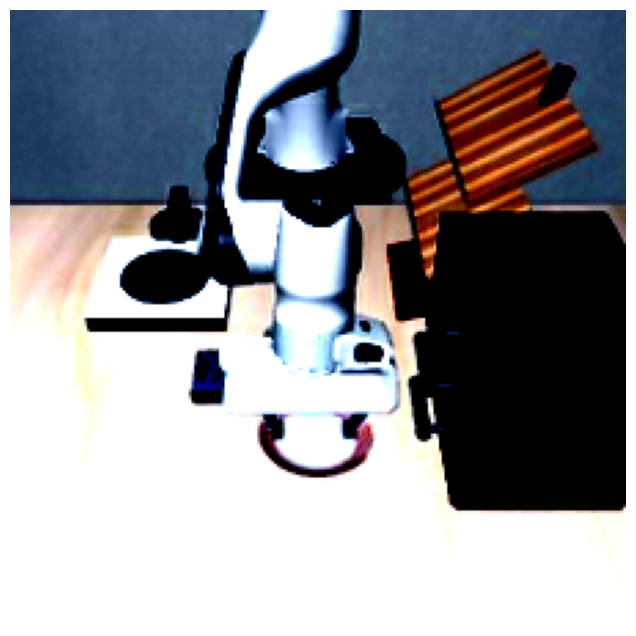

In [10]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

img = data["pixel_values"][0,0:3]  # Shape: [3, 224, 224]
print(img.shape)

# Convert from CHW to HWC format and scale to 0-255 range
img = img.permute(1, 2, 0)  # Shape: [224, 224, 3]
img = (img * 255).clamp(0, 255).to(torch.uint8)


# 将tensor转换为numpy数组并调整通道顺序
img_np = img.numpy()

# 创建新的图形
plt.figure(figsize=(8, 8))
plt.imshow(img_np)
plt.axis('off')  # 不显示坐标轴
plt.show()


torch.Size([3, 224, 224])


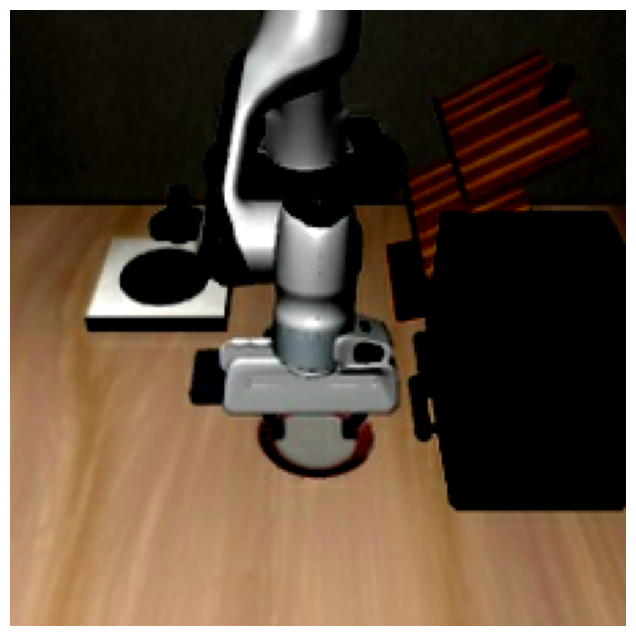

In [11]:
img = data["pixel_values"][0,3:6]  # Shape: [3, 224, 224]
print(img.shape)

# Convert from CHW to HWC format and scale to 0-255 range
img = img.permute(1, 2, 0)  # Shape: [224, 224, 3]
img = (img * 255).clamp(0, 255).to(torch.uint8)


# 将tensor转换为numpy数组并调整通道顺序
img_np = img.numpy()

# 创建新的图形
plt.figure(figsize=(8, 8))
plt.imshow(img_np)
plt.axis('off')  # 不显示坐标轴
plt.show()